In [1]:
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import seaborn as sns
import librosa
import cv2
import matplotlib.pyplot as plt
import numpy as np

import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# file_path = 'data_mfcc_aug.csv'
# df = pd.read_csv(file_path)

In [0]:
link = 'https://drive.google.com/open?id=1UcPoHcZgFmejItc1FcIO-SF0rErQhW7l'

In [4]:
fluff, id = link.split('=')
print (id)

1UcPoHcZgFmejItc1FcIO-SF0rErQhW7l


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
df = pd.read_csv('Filename.csv')

In [6]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,label
0,-14.146636,-17.393934,-26.673644,-27.698061,-28.248122,-27.999279,-29.438322,-28.523528,-27.600598,-29.086704,-28.436230,-27.801527,-29.623006,-27.825924,-26.674306,-28.907570,-29.277048,-29.163086,-30.233022,-30.204329,-28.489634,-28.533290,-28.132981,-28.788838,-30.630235,-32.432407,-32.812527,-34.377095,-33.312813,-32.216379,-33.013817,-31.297935,-29.993079,-29.299199,-31.068256,-29.913259,-29.377382,-29.839246,-29.119795,-28.283690,...,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,-28.745329,anger
1,-9.861386,-13.770627,-29.714045,-31.259181,-31.670597,-31.526615,-30.456018,-30.308974,-30.708918,-30.035270,-29.998729,-28.793871,-27.684876,-29.309347,-30.036294,-28.813113,-28.577816,-29.090744,-28.417809,-25.838464,-23.530718,-26.328635,-29.858001,-33.069657,-32.338191,-30.328793,-32.082000,-31.883746,-29.980646,-29.918410,-31.911311,-31.798070,-33.513264,-30.224310,-29.216732,-31.212392,-30.194077,-29.074113,-30.084365,-27.593959,...,-27.292245,-26.791113,-26.796997,-26.096467,-25.208309,-29.111453,-29.111453,-29.111453,-29.111453,-29.111453,-29.111453,-29.111453,-29.111453,-29.111453,-29.111453,-29.111453,-29.111453,-29.111453,-29.111453,-29.111453,-29.111453,-29.111453,-29.111453,-29.111453,-29.111453,-29.111453,-29.111453,-29.111453,-29.111453,-29.111453,-29.111453,-29.111453,-29.111453,-29.111453,-29.111453,-29.111453,-29.111453,-29.111453,-29.111453,anger
2,-16.649676,-20.601113,-33.157565,-31.901663,-30.799279,-30.905825,-31.841404,-32.618360,-27.456481,-26.398847,-30.497426,-32.347955,-31.818124,-30.670661,-30.339094,-31.010371,-30.887000,-27.998359,-27.633115,-29.438499,-33.932094,-35.050232,-35.734625,-35.551207,-34.120291,-34.501502,-32.434834,-31.180655,-33.479445,-33.276338,-31.557041,-31.107274,-29.765307,-29.045640,-28.061166,-26.538132,-27.416181,-27.422723,-28.187787,-27.824533,...,-36.940158,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,-30.320206,anger
3,-13.563900,-16.855584,-27.072878,-28.570732,-28.295611,-27.895841,-28.099773,-28.243841,-29.134636,-29.515783,-28.764103,-29.238323,-28.333651,-26.144534,-25.418085,-26.303245,-25.523040,-27.209278,-26.317451,-25.639733,-28.318018,-29.239732,-29.911734,-31.129468,-29.447193,-24.282428,-27.020032,-32.456369,-32.368488,-34.001333,-34.099794,-32.300204,-32.485214,-33.456334,-32.427148,-32.519549,-34.012126,-31.795253,-31.723228,-30.415406,...,-24.190413,-25.124869,-24.971255,-24.995052,-24.199807,-23.153656,-21.766557,-21.951646,-23.311520,-23.880534,-24.144269,-27.227011,-29.579303,-32.368997,-34.686619,-36.158392,-34.120696,-29.357926,-29.357926,-29.357926,-29.357926,-29.357926,-29.357926,-29.357926,-29.357926,-29.357926,-29.357926,-29.357926,-29.357926,-29.357926,-29.357926,-29.357926,-29.357926,-29.357926,-29.357926,-29.357926,-29.357926,-29.357926,-29.357926,anger
4,-16.221396,-19.342689,-27.604158,-30.221644,-27.598509,-26.778208,-27.475236,-21.830539,-16.241639,-14.319386,-16.126212,-18.179747,-18.064499,-16.938136,-16.130984,-15.842817,-18.510806,-20.087254,

In [7]:
#shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

df_train, df_test = train_test_split(df, stratify = df['label'], test_size = 0.07)
df_train, df_cv = train_test_split(df_train, stratify = df_train['label'], test_size = 0.07)
print('Number of observations in training data: ', len(df_train))
print('Number of observations in cross validation data: ', len(df_cv))
print('Number of observations in test data: ', len(df_test))

Number of observations in training data:  10264
Number of observations in cross validation data:  773
Number of observations in test data:  831


In [0]:
df_train = df_train.reset_index(drop=True)
df_cv = df_cv.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [0]:
# function to plot graphs
# https://seaborn.pydata.org/generated/seaborn.countplot.html

def plot_bar_graph(df, title):
    fig = plt.figure(figsize = (10, 6))
    ax = fig.add_axes([0,0,1,1])
    ax.set_title(title, fontsize = 15)
    sns.countplot(x = "label", data = df)
    for i in ax.patches:
        ax.text(x = i.get_x() + 0.2, y = i.get_height()+1.5, s = str(i.get_height()), fontsize = 20, color = "grey")
    plt.xlabel("")
    plt.ylabel("Count", fontsize = 10)
    plt.tick_params(labelsize = 10)
    plt.xticks(rotation = 40)
    plt.show()

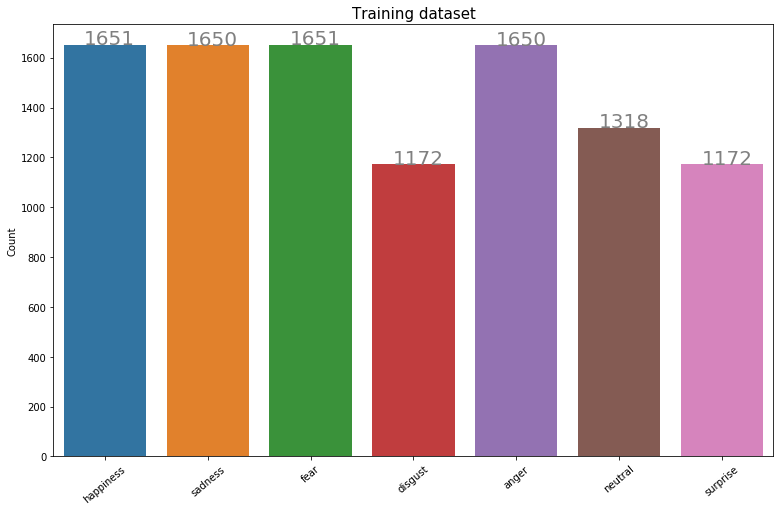

Percentage of images to fear: 16.0853% (1651)
Percentage of images to happiness: 16.0853% (1651)
Percentage of images to anger: 16.0756% (1650)
Percentage of images to sadness: 16.0756% (1650)
Percentage of images to neutral: 12.841% (1318)
Percentage of images to surprise: 11.4186% (1172)
Percentage of images to disgust: 11.4186% (1172)


In [10]:
# plotting graph of training dataset
plot_bar_graph(df_train, 'Training dataset')
x = df_train['label'].value_counts()
for i in range(len(x.index)):
    print(f'Percentage of images to {x.index[i]}: {np.round((x[i]/len(df_train))*100, 4)}% ({x[i]})')

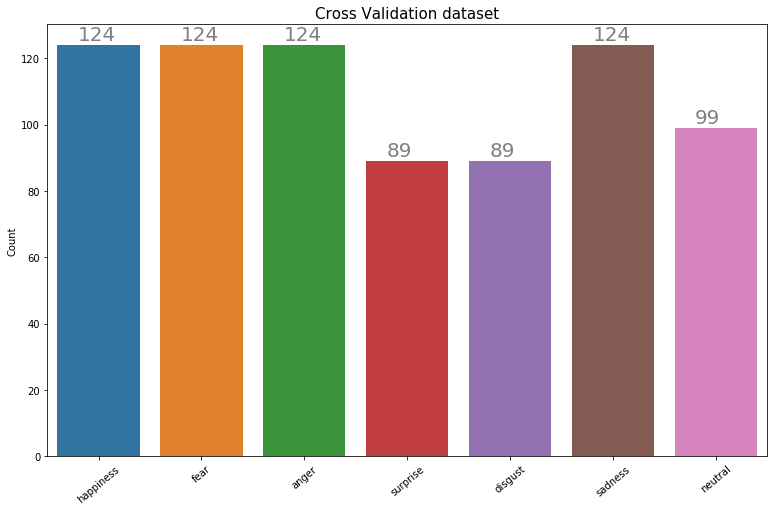

Percentage of images to anger: 16.0414% (124)
Percentage of images to fear: 16.0414% (124)
Percentage of images to sadness: 16.0414% (124)
Percentage of images to happiness: 16.0414% (124)
Percentage of images to neutral: 12.8072% (99)
Percentage of images to surprise: 11.5136% (89)
Percentage of images to disgust: 11.5136% (89)


In [11]:
# plotting graph of training dataset
plot_bar_graph(df_cv, 'Cross Validation dataset')
x = df_cv['label'].value_counts()
for i in range(len(x.index)):
    print(f'Percentage of images to {x.index[i]}: {np.round((x[i]/len(df_cv))*100, 4)}% ({x[i]})')

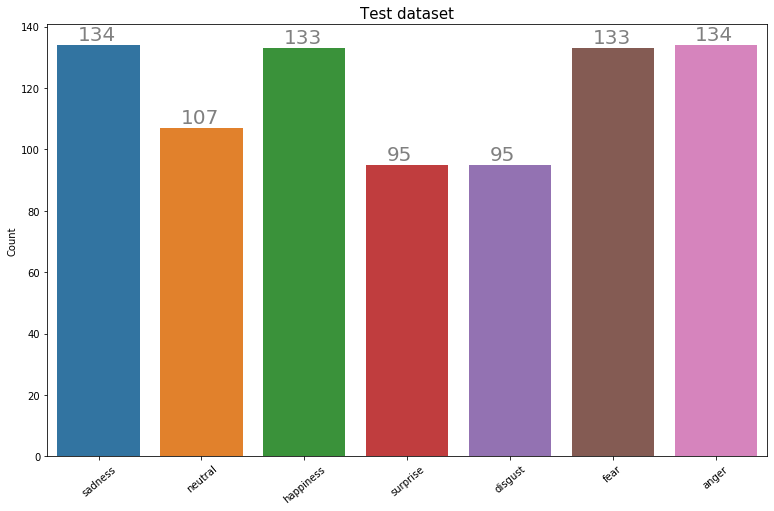

Percentage of images to anger: 16.1252% (134)
Percentage of images to sadness: 16.1252% (134)
Percentage of images to fear: 16.0048% (133)
Percentage of images to happiness: 16.0048% (133)
Percentage of images to neutral: 12.8761% (107)
Percentage of images to surprise: 11.432% (95)
Percentage of images to disgust: 11.432% (95)


In [12]:
# plotting graph of training dataset
plot_bar_graph(df_test, 'Test dataset')
x = df_test['label'].value_counts()
for i in range(len(x.index)):
    print(f'Percentage of images to {x.index[i]}: {np.round((x[i]/len(df_test))*100, 4)}% ({x[i]})')

In [0]:
X_train = df_train.drop(['label'], axis = 1)
X_test = df_test.drop(['label'], axis = 1)
X_cv = df_cv.drop(['label'], axis = 1)

y_train = df_train.label
y_test = df_test.label
y_cv = df_cv.label

In [14]:
y_train.value_counts()

fear         1651
happiness    1651
anger        1650
sadness      1650
neutral      1318
surprise     1172
disgust      1172
Name: label, dtype: int64

In [15]:
y_test.value_counts()

anger        134
sadness      134
fear         133
happiness    133
neutral      107
surprise      95
disgust       95
Name: label, dtype: int64

In [0]:
X_train = np.array(X_train)
y_train = np.array(y_train)


X_test = np.array(X_test)
y_test = np.array(y_test)

X_cv = np.array(X_cv)
y_cv = np.array(y_cv)

lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))
y_cv = np_utils.to_categorical(lb.fit_transform(y_cv))

In [18]:
X_train.shape

(10264, 259)

__Training Phase__

In [0]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)
x_cvcnn = np.expand_dims(X_cv, axis = 2)

In [20]:
model = Sequential()
model.add(Conv1D(259, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(7))
model.add(Activation('softmax'))
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [21]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [22]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=80, validation_data=(x_cvcnn, y_cv))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 10264 samples, validate on 773 samples
Epoch 1/80





10264/10264 [==============================] - 269s 26ms/step - loss: 1.9247 - acc: 0.2005 - val_loss: 1.8833 - val_acc: 0.2277
Epoch 2/80
10264/10264 [==============================] - 269s 26ms/step - loss: 1.8329 - acc: 0.2833 - val_loss: 1.8492 - val_acc: 0.2717
Epoch 3/80
10264/10264 [==============================] - 267s 26ms/step - loss: 1.7805 - acc: 0.3373 - val_loss: 1.8001 - val_acc: 0.3273
Epoch 4/80
10264/10264 [==============================] - 265s 26ms/step - loss: 1.7297 - acc: 0.3744 - val_loss: 1.7859 - val_acc: 0.3118
Epoch 5/80
10264/10264 [==============================] - 267s 26ms/step - loss: 1.6755 - acc: 0.4121 - val_loss: 1.7489 - val_acc: 0.3441
Epoch 6/80
10264/10264 [==============================] - 265s 26ms/step - loss: 1.6338 - acc: 0.4385 - val_loss: 1.6906 - val_acc: 0.4657
Epoch 7/80
10264

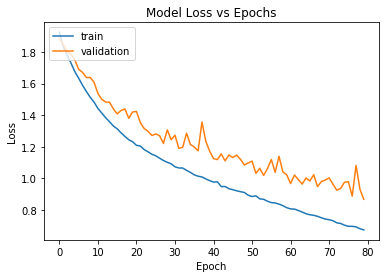

In [25]:
#plotting the graph of training and cross-validation loss

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('Model Loss vs Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

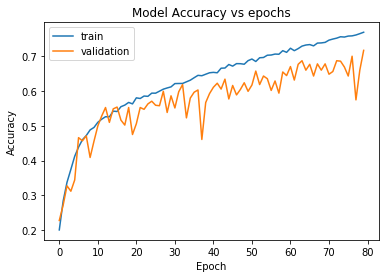

In [26]:
#plotting the graph of training and cross-validation accuracy

plt.plot(cnnhistory.history['acc'])
plt.plot(cnnhistory.history['val_acc'])
plt.title('Model Accuracy vs epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [27]:
score, acc = model.evaluate(x_testcnn, y_test)
print("Accuracy on test data: %.2f%%" % (acc*100))

831/831 [==============================] - 5s 6ms/step
Accuracy on test data: 73.53%


In [0]:
def convert_labels(y_prob):
    y = [np.argmax(i) for i in y_prob]
    y = np.array(y, dtype = np.int32)
    return y

In [0]:
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 1.1456040372438194
Test accuracy: 0.614732725213062


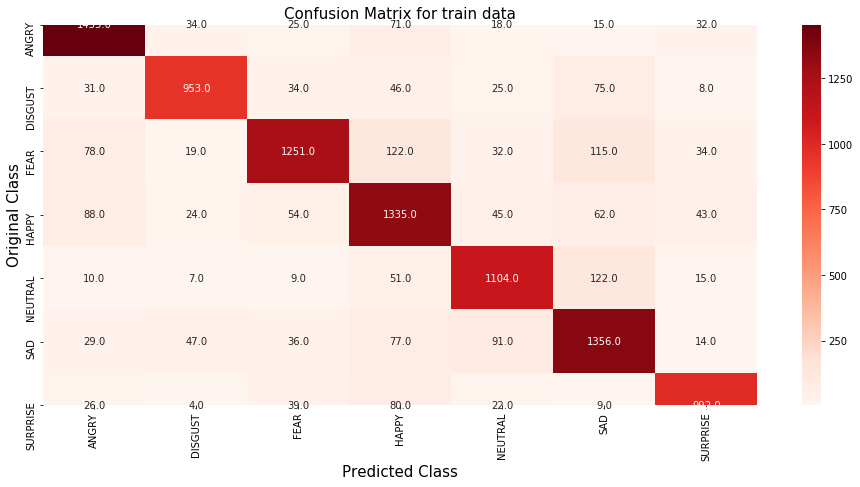

In [30]:
# plotting confusion matrix for train data
# https://www.kaggle.com/diegosch/classifier-evaluation-using-confusion-matrix

y_train_pred = model.predict(x_traincnn)

cm = confusion_matrix(convert_labels(y_train), convert_labels(y_train_pred))
labels = ["ANGRY", "DISGUST", "FEAR", "HAPPY", "NEUTRAL", "SAD", "SURPRISE"]
cm_df = pd.DataFrame(cm, index = labels, columns = labels)

# plt.figure(figsize=(16, 8))
plt.figure(figsize=(16,7))
sns.heatmap(cm, cmap = plt.get_cmap('Reds'), annot = True, fmt = ".1f", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix for train data", fontsize = 15)
plt.xlabel('Predicted Class', fontsize = 15)
plt.ylabel('Original Class', fontsize = 15)
plt.tick_params(labelsize = 10)
plt.xticks(rotation = 90)
plt.show()

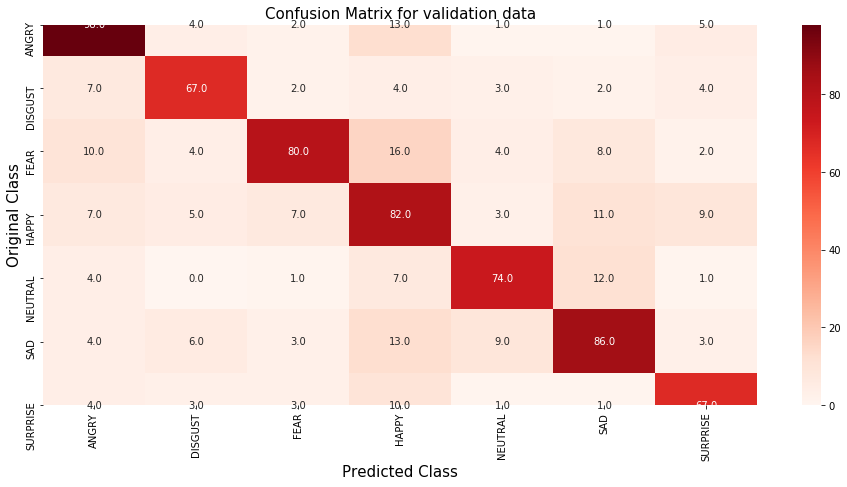

In [32]:
# plotting confusion matrix for validation data
# https://www.kaggle.com/diegosch/classifier-evaluation-using-confusion-matrix

y_cv_pred = model.predict(x_cvcnn)

cm = confusion_matrix(convert_labels(y_cv), convert_labels(y_cv_pred))
labels = ["ANGRY", "DISGUST", "FEAR", "HAPPY", "NEUTRAL", "SAD", "SURPRISE"]
cm_df = pd.DataFrame(cm, index = labels, columns = labels)

# plt.figure(figsize=(16, 8))
plt.figure(figsize=(16,7))
sns.heatmap(cm, cmap = plt.get_cmap('Reds'), annot = True, fmt = ".1f", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix for validation data", fontsize = 15)
plt.xlabel('Predicted Class', fontsize = 15)
plt.ylabel('Original Class', fontsize = 15)
plt.tick_params(labelsize = 10)
plt.xticks(rotation = 90)
plt.show()

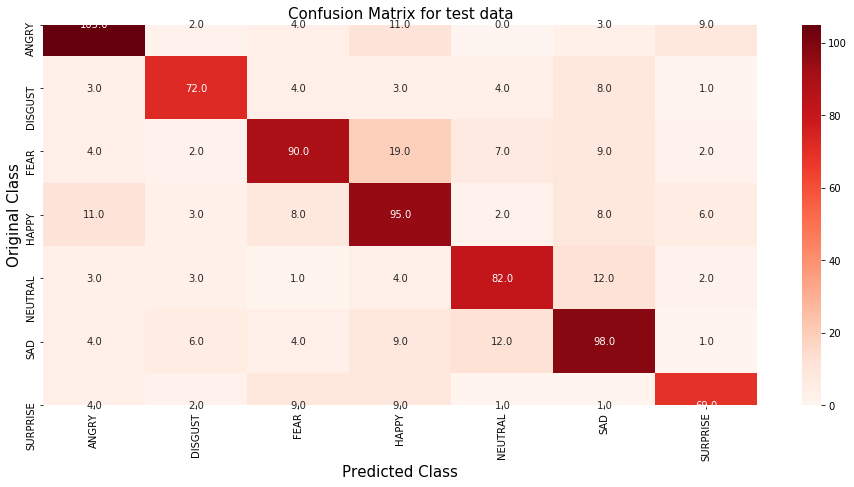

In [33]:
# plotting confusion matrix for test data
# https://www.kaggle.com/diegosch/classifier-evaluation-using-confusion-matrix

y_test_pred = model.predict(x_testcnn)

cm = confusion_matrix(convert_labels(y_test), convert_labels(y_test_pred))
labels = ["ANGRY", "DISGUST", "FEAR", "HAPPY", "NEUTRAL", "SAD", "SURPRISE"]
cm_df = pd.DataFrame(cm, index = labels, columns = labels)

# plt.figure(figsize=(16, 8))
plt.figure(figsize=(16,7))
sns.heatmap(cm, cmap = plt.get_cmap('Reds'), annot = True, fmt = ".1f", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix for test data", fontsize = 15)
plt.xlabel('Predicted Class', fontsize = 15)
plt.ylabel('Original Class', fontsize = 15)
plt.tick_params(labelsize = 10)
plt.xticks(rotation = 90)
plt.show()

In [35]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 132681 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.13-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [36]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [37]:
model_json = model.to_json()
with open("drive/My Drive/model_audio_1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("drive/My Drive/model_audio_1_weights.h5")
print("Saved model to drive")

Saved model to drive
